## getting the data and all the necessary text files and functions

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [2]:
# !wget -q https://git.io/J0fjL -O IAM_Words.zip
# !unzip -qq IAM_Words.zip
# !
# !mkdir data
# !mkdir data\words
# !tar -xf IAM_Words\words.tgz -C data/words
# !move IAM_Words\words.txt data

In [3]:
data_location = '/data/words'
words_txt_location = 'data/words.txt'

In [4]:
def get_paths_and_gts(partition_split_file):
    """
    read a string like(which can be found in each line of words.txt file):
    'a01-000u-00-00 ok 154 408 768 27 51 AT A'
    and extract 'a01-000u-00-00': location of the image with sub-folders, to read it from the directories
                'ok'            : processing status. ok means good, presumably.
                'A'             : ground truth text

    Then, pre-process using function defined above
    """
    # a list to store paths to images and ground truth texts
    paths_and_gts = []
    
    # open the file
    with open(partition_split_file) as f:
        # go through each line
        for line in f:
            # if a line is empty or commented with #, ignore that line
            if not line or line.startswith('#'):
                continue
            
            # in the text file, each line is seperated with '\n', so `strip` first
            # then string like 'a01-000u-00-00 ok 154 408 768 27 51 AT A' has to split to a list by spaces
            line_split = line.strip().split(' ')
            
            # the first item of the list contains path information, so split that by '-'
            directory_split = line_split[0].split('-')
            
            # now use all the above and concatenate to a string to make a path to an image
            image_location = f'{data_location}/{directory_split[0]}/{directory_split[0]}-{directory_split[1]}/{line_split[0]}.png'
            
            # in a string like 'a01-000u-00-00 ok 154 408 768 27 51 AT A', text from 9th split is the ground truth text.
            gt_text = ' '.join(line_split[8:])
            
            # ignore a sample(image and ground truth text), if the ground truth has more than 16 letters
            # if len(gt_text) > 16:
                # continue
            
            # now, append the image location and ground truth text of that image as a list to 
            paths_and_gts.append([image_location, gt_text])
    
    return paths_and_gts

## pre-processing

In [5]:
def add_padding(img, old_w, old_h, new_w, new_h):
    h1, h2 = int((new_h - old_h) / 2), int((new_h - old_h) / 2) + old_h
    w1, w2 = int((new_w - old_w) / 2), int((new_w - old_w) / 2) + old_w
    img_pad = np.ones([new_h, new_w, 3]) * 255
    img_pad[h1:h2, w1:w2, :] = img
    return img_pad


def fix_size(img, target_w, target_h):
    h, w = img.shape[:2]
    if w < target_w and h < target_h:
        img = add_padding(img, w, h, target_w, target_h)
    elif w >= target_w and h < target_h:
        new_w = target_w
        new_h = int(h * new_w / w)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    elif w < target_w and h >= target_h:
        new_h = target_h
        new_w = int(w * new_h / h)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    else:
        """w>=target_w and h>=target_h """
        ratio = max(w / target_w, h / target_h)
        new_w = max(min(target_w, int(w / ratio)), 1)
        new_h = max(min(target_h, int(h / ratio)), 1)
        new_img = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
        img = add_padding(new_img, new_w, new_h, target_w, target_h)
    return img


def preprocess(path, img_w, img_h):
    """ Pre-processing image for predicting """
    img = cv2.imread(path)
    img = fix_size(img, img_w, img_h)

    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = img.astype(np.float32)
    img /= 255
    return img

In [6]:
letters = [' ', '!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/',
           '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?',
           'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
           'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
           'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

num_classes = len(letters) + 1
print(num_classes)

80


## generating all the pre-processed vectors

In [7]:
def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

In [8]:
train_files = get_paths_and_gts('data/train_files.txt')
valid_files = get_paths_and_gts('data/valid_files.txt')
test_files = get_paths_and_gts('data/test_files.txt')
len(train_files), len(valid_files), len(test_files)

(87292, 4316, 4316)

In [9]:
# since this image is not readable is not readable, it has to be discarded.
# ../words/r06/r06-022/r06-022-03-05.png'

for index, (img_loc, gt_text) in enumerate(train_files):
    if 'r06-022-03-05' in img_loc:
        print(index)
    else:
        continue

4576


In [10]:
train_files[4576]

['/data/words/r06/r06-022/r06-022-03-05.png', 'more']

In [11]:
del train_files[4576]
print(train_files[4576])

['/data/words/g06/g06-042e/g06-042e-05-03.png', 'notice']


this is how images used for training will look like.

CITIZENS


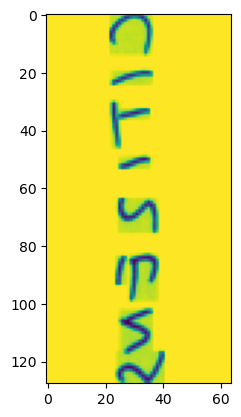

In [12]:
i = 21
path=train_files[i][0]
path=path[1:]
# print(path)
print(train_files[i][1])
an_img = preprocess(path, img_w=128, img_h=64)
plt.imshow(an_img.T)

In [13]:
class TextImageGenerator:
    
    def __init__(self, data,
                 img_w,
                 img_h, 
                 batch_size, 
                 i_len,
                 max_text_len):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.samples = data
        self.n = len(self.samples)
        self.i_len = i_len
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        for i, (img_filepath, text) in enumerate(self.samples):
            img_filepath=img_filepath[1:]
            img = preprocess(img_filepath, self.img_w, self.img_h)
            if img is None:
                print(f"Error processing image: {img_filepath}")
            self.imgs[i, :, :] = img
            self.texts.append(text)

    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * self.i_len
            label_length = np.zeros((self.batch_size, 1))
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i, :len(text)] = text_to_labels(text)
                label_length[i] = len(text)
                
            inputs = [X_data, Y_data, input_length, label_length]
            outputs = np.zeros([self.batch_size])
            yield (inputs, outputs)

In [14]:
batch_size = 64
input_length = 30
max_text_len = 16
img_w = 128
img_h = 64

In [15]:
train_data = TextImageGenerator(train_files, img_w, img_h, batch_size, input_length, max_text_len)
train_data.build_data()

In [16]:
train_data.imgs.shape

(87291, 64, 128)

In [17]:
validation_data = TextImageGenerator(valid_files, img_w, img_h, batch_size, input_length, max_text_len)
validation_data.build_data()

# making model

In [18]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import backend as tf_keras_backend

tf_keras_backend.set_image_data_format('channels_last')
tf_keras_backend.image_data_format()

'channels_last'

In [19]:
input_data = layers.Input(name='the_input', shape=(128,64,1), dtype='float32')  # (None, 128, 64, 1)

# Convolution layer (VGG)
iam_layers = layers.Conv2D(64, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max1')(iam_layers)  # (None,64, 32, 64)

iam_layers = layers.Conv2D(128, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(2, 2), name='max2')(iam_layers)

iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(256, (3, 3), padding='same', name='conv4', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max3')(iam_layers)  # (None, 32, 8, 256)

iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv5', kernel_initializer='he_normal')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.Conv2D(512, (3, 3), padding='same', name='conv6')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)
iam_layers = layers.MaxPooling2D(pool_size=(1, 2), name='max4')(iam_layers)

iam_layers = layers.Conv2D(512, (2, 2), padding='same', kernel_initializer='he_normal', name='con7')(iam_layers)
iam_layers = layers.BatchNormalization()(iam_layers)
iam_layers = layers.Activation('relu')(iam_layers)

# CNN to RNN
iam_layers = layers.Reshape(target_shape=((32, 2048)), name='reshape')(iam_layers)
iam_layers = layers.Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(iam_layers)

# RNN layer
gru_1 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru1')(iam_layers)
gru_1b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(iam_layers)
reversed_gru_1b = layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (gru_1b)

gru1_merged = layers.add([gru_1, reversed_gru_1b])
gru1_merged = layers.BatchNormalization()(gru1_merged)

gru_2 = layers.GRU(256, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = layers.GRU(256, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
reversed_gru_2b= layers.Lambda(lambda inputTensor: tf_keras_backend.reverse(inputTensor, axes=1)) (gru_2b)

gru2_merged = layers.concatenate([gru_2, reversed_gru_2b])
gru2_merged = layers.BatchNormalization()(gru2_merged)

# transforms RNN output to character activations:
iam_layers = layers.Dense(80, kernel_initializer='he_normal', name='dense2')(gru2_merged)
iam_outputs = layers.Activation('softmax', name='softmax')(iam_layers)

labels = layers.Input(name='the_labels', shape=[16], dtype='float32')
input_length = layers.Input(name='input_length', shape=[1], dtype='int64')
label_length = layers.Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return tf_keras_backend.ctc_batch_cost(labels, y_pred, input_length, label_length)


# loss function
loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([iam_outputs, labels, input_length, label_length])

model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 128, 64, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 64, 64)          640       ['the_input[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 128, 64, 64)          256       ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 64, 64)          0         ['batch_normalization[0]

                                                                     'lambda[0][0]']              
                                                                                                  
 batch_normalization_7 (Bat  (None, 32, 256)              1024      ['add[0][0]']                 
 chNormalization)                                                                                 
                                                                                                  
 gru2_b (GRU)                (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 gru2 (GRU)                  (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
          

In [20]:
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')
# you will know, why there aren't any metrics

In [21]:
import time
from tensorflow.keras.callbacks import Callback
from datetime import datetime

class EpochTimeHistory(Callback):
    """
    a custom callback to print the time(in minutes, to console) each epoch took during.
    """
    def on_train_begin(self, logs={}):
        self.train_epoch_times = []
        self.valid_epoch_times = []
    
    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
            cur_epoch_time = round((time.time() - self.epoch_time_start)/60, 4)
            self.train_epoch_times.append(cur_epoch_time )
            # cur_epoch_time = datetime.strptime(str(cur_epoch_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
            self.train_epoch_times.append(cur_epoch_time)
            print(" ;epoch {0} took {1} minutes.".format(epoch+1, cur_epoch_time))
    
    ## functions used below are for recording validation times
    def on_test_begin(self, logs={}):
        self.test_time_start = time.time()

    def on_test_end(self, logs={}):
        cur_test_time = round((time.time() - self.test_time_start)/60, 4)
        self.valid_epoch_times.append(cur_test_time)
        # cur_test_time = datetime.strptime(str(cur_test_time), "%H:%M:%S.%f").strftime('%H:%M:%S')
        print(" ;validation took {0} minutes.".format(cur_test_time))

In [22]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_save_cb = ModelCheckpoint(filepath='Model/',
                                verbose=1, save_best_only=False, monitor='val_loss', save_weights_only=False)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
# reduce_learning_rate_cb = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, cooldown=2, min_lr=0.00001, verbose=1)
epoch_times = EpochTimeHistory()

In [23]:
batch_size, train_data.n, validation_data.n

(64, 87291, 4316)

In [24]:
history_model_3 = model.fit(train_data.next_batch(),
                            validation_data=validation_data.next_batch(),
                            steps_per_epoch=train_data.n/batch_size,
                            validation_steps=validation_data.n // batch_size,
                            epochs=10, verbose=1,
                            callbacks=[earlystop, model_save_cb, epoch_times])

Epoch 1/10

1364/1363 [==============================] - ETA: 0s - loss: 9.4672 ;validation took 0.6888 minutes.

Epoch 1: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 1 took 51.8995 minutes.
1363/1363 [==============================] - 3114s 2s/step - loss: 9.4672 - val_loss: 5.8850
Epoch 2/10
1364/1363 [==============================] - ETA: 0s - loss: 3.1909 ;validation took 0.9104 minutes.

Epoch 2: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 2 took 53.3979 minutes.
1363/1363 [==============================] - 3204s 2s/step - loss: 3.1909 - val_loss: 2.6588
Epoch 3/10
1364/1363 [==============================] - ETA: 0s - loss: 2.1161 ;validation took 0.8176 minutes.

Epoch 3: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 3 took 57.7473 minutes.
1363/1363 [==============================] - 3465s 3s/step - loss: 2.1161 - val_loss: 2.0557
Epoch 4/10
1364/1363 [==============================] - ETA: 0s - loss: 1.6787 ;validation took 0.8549 minutes.

Epoch 4: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 4 took 52.9954 minutes.
1363/1363 [==============================] - 3180s 2s/step - loss: 1.6787 - val_loss: 2.2355
Epoch 5/10
1364/1363 [==============================] - ETA: 0s - loss: 1.3956 ;validation took 0.9979 minutes.

Epoch 5: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 5 took 58.7971 minutes.
1363/1363 [==============================] - 3528s 3s/step - loss: 1.3956 - val_loss: 1.4949
Epoch 6/10
1364/1363 [==============================] - ETA: 0s - loss: 1.2000 ;validation took 1.0053 minutes.

Epoch 6: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 6 took 68.4679 minutes.
1363/1363 [==============================] - 4108s 3s/step - loss: 1.2000 - val_loss: 2.5405
Epoch 7/10
1364/1363 [==============================] - ETA: 0s - loss: 1.0411 ;validation took 1.0193 minutes.

Epoch 7: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 7 took 68.7068 minutes.
1363/1363 [==============================] - 4122s 3s/step - loss: 1.0411 - val_loss: 1.0297
Epoch 8/10
1364/1363 [==============================] - ETA: 0s - loss: 0.9048 ;validation took 1.0004 minutes.

Epoch 8: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 8 took 67.8953 minutes.
1363/1363 [==============================] - 4074s 3s/step - loss: 0.9048 - val_loss: 0.9068
Epoch 9/10
1364/1363 [==============================] - ETA: 0s - loss: 0.7909 ;validation took 1.1047 minutes.

Epoch 9: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 9 took 70.2413 minutes.
1363/1363 [==============================] - 4214s 3s/step - loss: 0.7909 - val_loss: 15.5314
Epoch 10/10
1364/1363 [==============================] - ETA: 0s - loss: 0.7081 ;validation took 1.16 minutes.

Epoch 10: saving model to Model\
INFO:tensorflow:Assets written to: Model\assets


INFO:tensorflow:Assets written to: Model\assets


 ;epoch 10 took 77.2087 minutes.
1363/1363 [==============================] - 4633s 3s/step - loss: 0.7081 - val_loss: 0.7792


In [25]:
model.save(filepath='Model/', overwrite=False, include_optimizer=True)

[WARNING] Model/ already exists - overwrite? [y/n]y
[TIP] Next time specify overwrite=True!
INFO:tensorflow:Assets written to: Model/assets


INFO:tensorflow:Assets written to: Model/assets


## plotting model statistics

In [26]:
import seaborn as sns

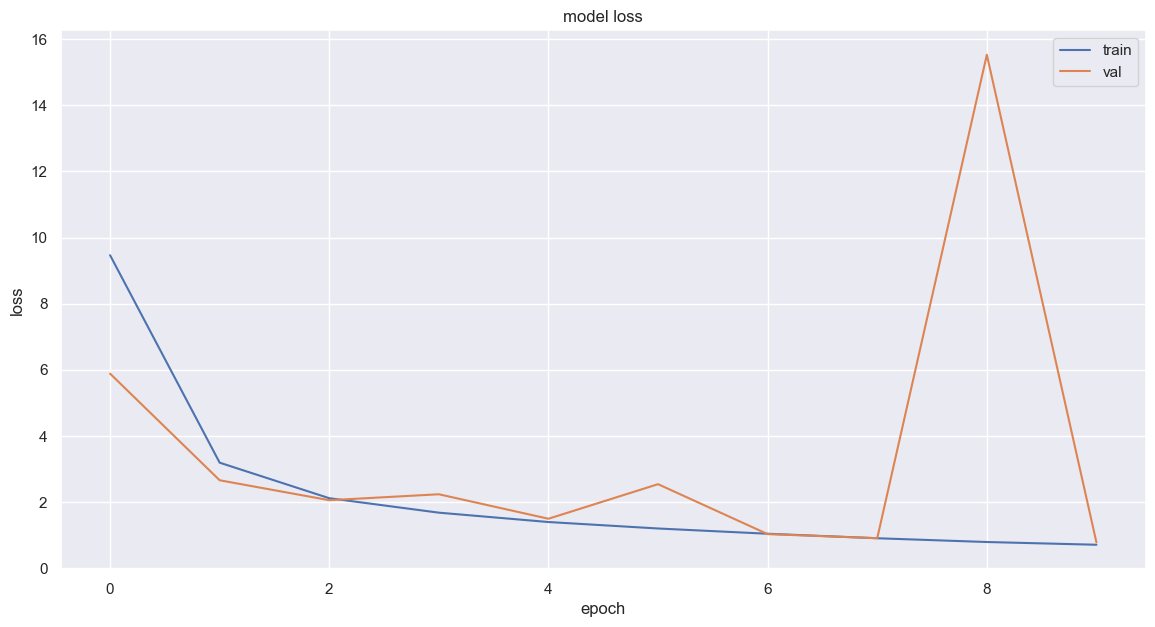

In [27]:
sns.set(rc={'figure.figsize':(14,7)})
plt.plot(history_model_3.history['loss'])
plt.plot(history_model_3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='best')
plt.show()

In [28]:
history_model_3.history.keys()

dict_keys(['loss', 'val_loss'])

In [29]:
import pandas as pd

In [30]:
loss_df = pd.DataFrame(data=history_model_3.history)
loss_df.head()

,loss,val_loss
0,9.467205,5.885032
1,3.190926,2.658814
2,2.116050,2.055682
3,1.678729,2.235462
4,1.395586,1.494922


In [31]:
loss_df.sort_values(by=['loss', 'val_loss']).head()

,loss,val_loss
9,0.708135,0.779229
8,0.790920,15.531428
7,0.904842,0.906788
6,1.041070,1.029725
5,1.199981,2.540453


In [32]:
loss_df.sort_values(by=['val_loss', 'loss']).head()

,loss,val_loss
9,0.708135,0.779229
7,0.904842,0.906788
6,1.041070,1.029725
4,1.395586,1.494922
2,2.116050,2.055682


so, let's use the weights of 30th(labelled 29 above) and 28th(labelled 27 above) epochs.

## predictions on test set and calculating WER & CER

make predictions using weights from various checkpoints, since that's the epoch with lowest train and validation error.

biographies


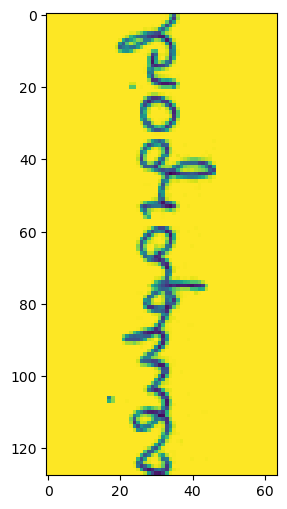

In [33]:
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 1
path=test_files[i][0]
path=path[1:]
print(test_files[i][1])
temp_processed_image = preprocess(path, img_w=128, img_h=64)
plt.imshow(temp_processed_image.T)

In [34]:
test_images_processed = []
original_test_texts = []
for _, (test_image_path, original_test_text) in enumerate(test_files):
     temp_processed_image = preprocess(path=test_image_path[1:], img_w=128, img_h=64)
     test_images_processed.append(temp_processed_image.T)
     original_test_texts.append(original_test_text)

In [35]:
print(len(test_files))
print(len(test_images_processed))
print(len(original_test_texts))

4316
4316
4316


In [36]:
test_images_processed = np.array(test_images_processed)
test_images_processed.shape

(4316, 128, 64)

In [37]:
test_images_processed = test_images_processed.reshape(4316, 128, 64, 1)
test_images_processed.shape

(4316, 128, 64, 1)

biographies


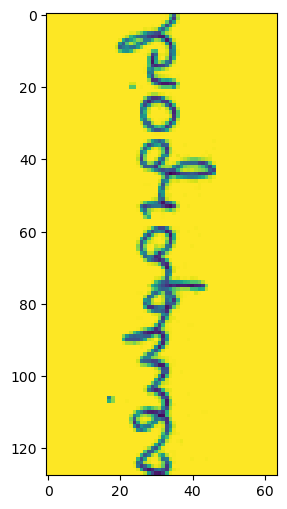

In [38]:
sns.reset_orig()
plt.figure(figsize=(3, 6))
i = 1
print(test_files[i][1])
plt.imshow(test_images_processed[i].reshape(128,64))

### iam with weights of final and 30th epoch. (the one with least loss on train data)

In [39]:
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 128, 64, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 64, 64)          640       ['the_input[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 128, 64, 64)          256       ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 64, 64)          0         ['batch_normalization[0]

                                                                                                  
 gru2_b (GRU)                (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 gru2 (GRU)                  (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 lambda_1 (Lambda)           (None, 32, 256)              0         ['gru2_b[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 32, 512)              0         ['gru2[0][0]',                
          

In [40]:
iam_model_pred.load_weights(filepath='Model')

In [41]:
test_predictions_encoded = iam_model_pred.predict(x=test_images_processed)
test_predictions_encoded.shape

135/135 [==============================] - 95s 694ms/step


(4316, 32, 80)

In [42]:
# use CTC decoder to decode to text
test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(test_predictions_encoded,
                                                                                  input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
                                                                                  greedy=True)[0][0])
test_predictions_decoded.shape

(4316, 32)

In [43]:
def numbered_array_to_text(numbered_array):
    numbered_array = numbered_array[numbered_array != -1]
    return "".join(letters[i] for i in numbered_array)

In [44]:
for i in range(10):
    print("original_text = ", original_test_texts[i])
    print("predicted text = ", numbered_array_to_text(test_predictions_decoded[i]))
    print()

original_text =  certain
predicted text =  scentain

original_text =  biographies
predicted text =  jisiographies

original_text =  all
predicted text =  zall

original_text =  It
predicted text =  It

original_text =  I
predicted text =  I

original_text =  show
predicted text =  show

original_text =  Kings
predicted text =  Kings

original_text =  A
predicted text =  A

original_text =  the
predicted text =  Tthe

original_text =  and
predicted text =  zand



### with weights of 28th epoch (the one with the least loss of validation data)

In [45]:
iam_model_pred = None
iam_model_pred = Model(inputs=input_data, outputs=iam_outputs)
iam_model_pred.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, 128, 64, 1)]         0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 128, 64, 64)          640       ['the_input[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 128, 64, 64)          256       ['conv1[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128, 64, 64)          0         ['batch_normalization[0]

                                                                                                  
 gru2_b (GRU)                (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 gru2 (GRU)                  (None, 32, 256)              394752    ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 lambda_1 (Lambda)           (None, 32, 256)              0         ['gru2_b[0][0]']              
                                                                                                  
 concatenate (Concatenate)   (None, 32, 512)              0         ['gru2[0][0]',                
          

In [46]:
iam_model_pred.load_weights(filepath='Model')

In [47]:
test_predictions_encoded = None
test_predictions_decoded = None

In [48]:
test_predictions_encoded = iam_model_pred.predict(x=test_images_processed)
# use CTC decoder to decode to text
test_predictions_decoded = tf_keras_backend.get_value(tf_keras_backend.ctc_decode(test_predictions_encoded,
                                                                                  input_length = np.ones(test_predictions_encoded.shape[0])*test_predictions_encoded.shape[1],
                                                                                  greedy=True)[0][0])
test_predictions_decoded.shape

135/135 [==============================] - 76s 550ms/step


(4316, 32)

In [51]:
for i in range(30):
    print("original_text = ", original_test_texts[i])
    print("predicted text = ", numbered_array_to_text(test_predictions_decoded[i]))
    print()

original_text =  certain
predicted text =  scentain

original_text =  biographies
predicted text =  jisiographies

original_text =  all
predicted text =  zall

original_text =  It
predicted text =  It

original_text =  I
predicted text =  I

original_text =  show
predicted text =  show

original_text =  Kings
predicted text =  Kings

original_text =  A
predicted text =  A

original_text =  the
predicted text =  Tthe

original_text =  and
predicted text =  zand

original_text =  .
predicted text =  :.

original_text =  to
predicted text =  Tto

original_text =  have
predicted text =  Thave

original_text =  new
predicted text =  ?inew

original_text =  were
predicted text =  were

original_text =  meant
predicted text =  Tmeant

original_text =  that
predicted text =  Tthat

original_text =  by
predicted text =  by

original_text =  didn't
predicted text =  didn't

original_text =  gesture
predicted text =  gesture

original_text =  town
predicted text =  Jtown

original_text =  .
predi

In [7]:
import tensorflow as tf

# Load the model
try:
    model = tf.keras.models.load_model('Model/')
    print("Model loaded successfully!")
except Exception as e:
    print("Error loading the model:", e)

# If loading fails, inspect the model structure
if not model:
    try:
        # Load the model architecture without weights
        model = tf.keras.models.load_model('Model/', compile=False)
        
        # Display model summary
        print("Model Summary:")
        print(model.summary())
        
        # Display model configuration
        print("\nModel Configuration:")
        print(model.get_config())
        
        # Iterate over layers and inspect Lambda layers
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Lambda):
                print("Lambda Layer:", layer)
                # Inspect lambda function
                print("Lambda Function:", layer.function)
                # You can also print other properties of the Lambda layer
                
    except Exception as e:
        print("Error inspecting the model structure:", e)


Error loading the model: Exception encountered when calling layer "lambda" (type Lambda).

name 'tf_keras_backend' is not defined

Call arguments received by layer "lambda" (type Lambda):
  • inputs=tf.Tensor(shape=(None, 32, 256), dtype=float32)
  • mask=None
  • training=None


NameError: name 'model' is not defined